In [82]:
import numpy as np 
from scipy.optimize import minimize 
from scipy import linalg 
import matplotlib.pyplot as plt
import random
%matplotlib inline

# np.random.seed(0) 
N = 100 
half_n = N//2 
r = 10 
s = r/16 
t = np.random.uniform(0, 2*np.pi, half_n) 
n = s*np.random.randn(half_n) 
x1 , y1 = (r + n)*np.cos(t), (r + n)*np.sin(t) 
X_circ = np.hstack((x1.reshape(half_n, 1) , y1.reshape(half_n , 1))) 

m, b = -1, 2 
x2 = np.linspace(-12, 12 , half_n) 
y2 = m*x2 + b + s*np.random.randn(half_n) 
X_line = np.hstack((x2.reshape(half_n , 1) , y2.reshape(half_n , 1))) 
X = np.vstack((X_circ , X_line))
y=y1 + y2


In [83]:
class RANSAC:
    def __init__(self,x_data,y_data,min_samples,dis_thres,num_samps):
        self.x_data=x_data
        self.y_data=y_data
        self.s=min_samples
        self.t=dis_thres
        self.N=num_samps
        self.best_model=None
        self.inliers=[]
        self.outliers=[]
        self.points=[]

    def distance(self,p1,p2):
        return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5

    def random_sample(self):
        self.points=[]
        i=0
        while i<self.s:
            ind=random.randint(0,len(self.x_data)-1)
            pnt=(self.x_data[ind],self.y_data[ind])
            if pnt not in self.points:
                self.points.append(pnt)
                i+=1

    def circle_equation(self):
        pt1,pt2,pt3=self.points
        Y = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]])
        Z = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])
        inverse_Y = linalg.inv(Y)
        c_x, c_y = np.dot(inverse_Y, Z) / 2
        cx, cy = c_x[0], c_y[0]
        r = np.sqrt((cx - pt1[0])**2 + (cy - pt1[1])**2)
        return cx, cy, r

    def inliers_filter(self):
        new_inliers=[]
        new_outliers=[]
        xc,yc,r=self.circle_equation()
        for i in range(len(self.x_data)):
            dist=self.distance((self.x_data[i],self.y_data[i]),(xc,yc))
            if abs(dist-r)<=self.t:
                new_inliers.append((self.x_data[i],self.y_data[i]))
            else:
                new_outliers.append((self.x_data[i],self.y_data[i]))
            
        if len(self.inliers)<len(new_inliers):
            self.inliers=new_inliers
            self.outliers=new_outliers
            self.best_model=(xc,yc,r)

    def model_finder(self):
        for i in range(self.N):
            self.random_sample()
            self.inliers_filter()

        return self.best_model
    
    

In [84]:
best_samp=RANSAC(X[:,0],X[:,1],3,1,35)
best_samp.model_finder()

(0.4888455144919101, -0.09431272130057618, 10.120053018309031)

In [85]:
ransac=RANSAC(np.array(best_samp.inliers)[:,0],np.array(best_samp.inliers)[:,1],3,1,35)
ransac.model_finder()

(0.17803075168441465, 0.32455742097881046, 10.156075710439708)

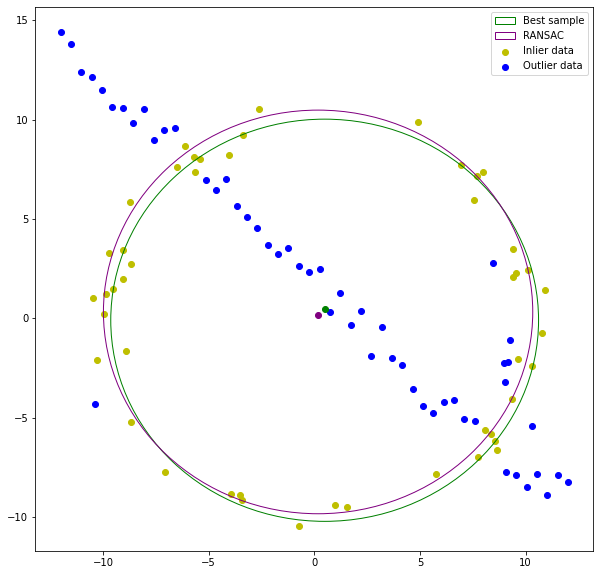

In [86]:
fig,ax=plt.subplots(figsize=(10,10))
ax.scatter(np.array(best_samp.inliers)[:,0],np.array(best_samp.inliers)[:,1],c='y',label='Inlier data')
ax.scatter(np.array(best_samp.outliers)[:,0],np.array(best_samp.outliers)[:,1],c='b',label='Outlier data')

circle1 = plt.Circle((best_samp.best_model[0], best_samp.best_model[1]), best_samp.best_model[2], color='green',fill=False,label='Best sample')
ax.add_patch(circle1)

circle2 = plt.Circle((ransac.best_model[0], ransac.best_model[1]), ransac.best_model[2], color='purple',fill=False,label='RANSAC')
ax.add_patch(circle2)

ax.scatter(best_samp.best_model[0],best_samp.best_model[0],c='green')
ax.scatter(ransac.best_model[0],ransac.best_model[0],c='purple')
ax.legend(loc='upper right')
plt.show()